In [174]:
import pandas as pd
from helpers import *
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, RejectOptionClassifierCV, PostProcessingMeta

In [175]:
## Load the pre-processed dataset.
df=pd.read_csv("./data/standard_df.csv")

## Load the xgboost dataset.
xgboost_df=pd.read_csv("./data/xgboost_df.csv")

## Create a list with the protected attributes that are going to be used. 
prot_attr=['Previous_qualification', 'Debtor', 'Tuition_fees_up_to_date']

In [176]:
## Split the dataset and standardize it. 

X_train, X_test, y_train, y_test, indices_train, indices_test=standardized_dataset_output(
                                                                                            df,
                                                                                            prot_attr,
                                                                                            'Target'
                                                                                        )

In [177]:
## Create two lists of metrics: one for the evaluation metrics and one for the fairness metrics.
eval_metrics=['Balanced Accuracy', 'f1-score', 'ROC-AUC']
fairness_metrics=['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']

### Calibrated Equalized Odds

In [25]:
model=PostProcessingMeta(XGBClassifier(), CalibratedEqualizedOdds(prot_attr[1], cost_constraint="fnr", random_state=0), random_state=0)

In [26]:
grid=model.fit(X_train, y_train)
y_pred=grid.predict(X_test)
y_proba=grid.predict_proba(X_test)[:,1]

c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\sklearn\utils\metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\sklearn\utils\metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(


In [27]:
cal_df=create_metrics_dataset(y_test, y_pred, y_proba, prot_attr)

cal_df.to_csv('./data/cal_df.csv')

In [11]:
cal_df

,Unnamed: 0,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,0,Previous_qualification,0.8946,0.9256,0.9486,0.5361,5.8250,0.4573,0.3133
1,1,Debtor,0.8946,0.9256,0.9486,0.4488,2.7954,0.1543,0.1097
2,2,Tuition_fees_up_to_date,0.8946,0.9256,0.9486,-0.6779,0.0753,-0.4601,-0.3264


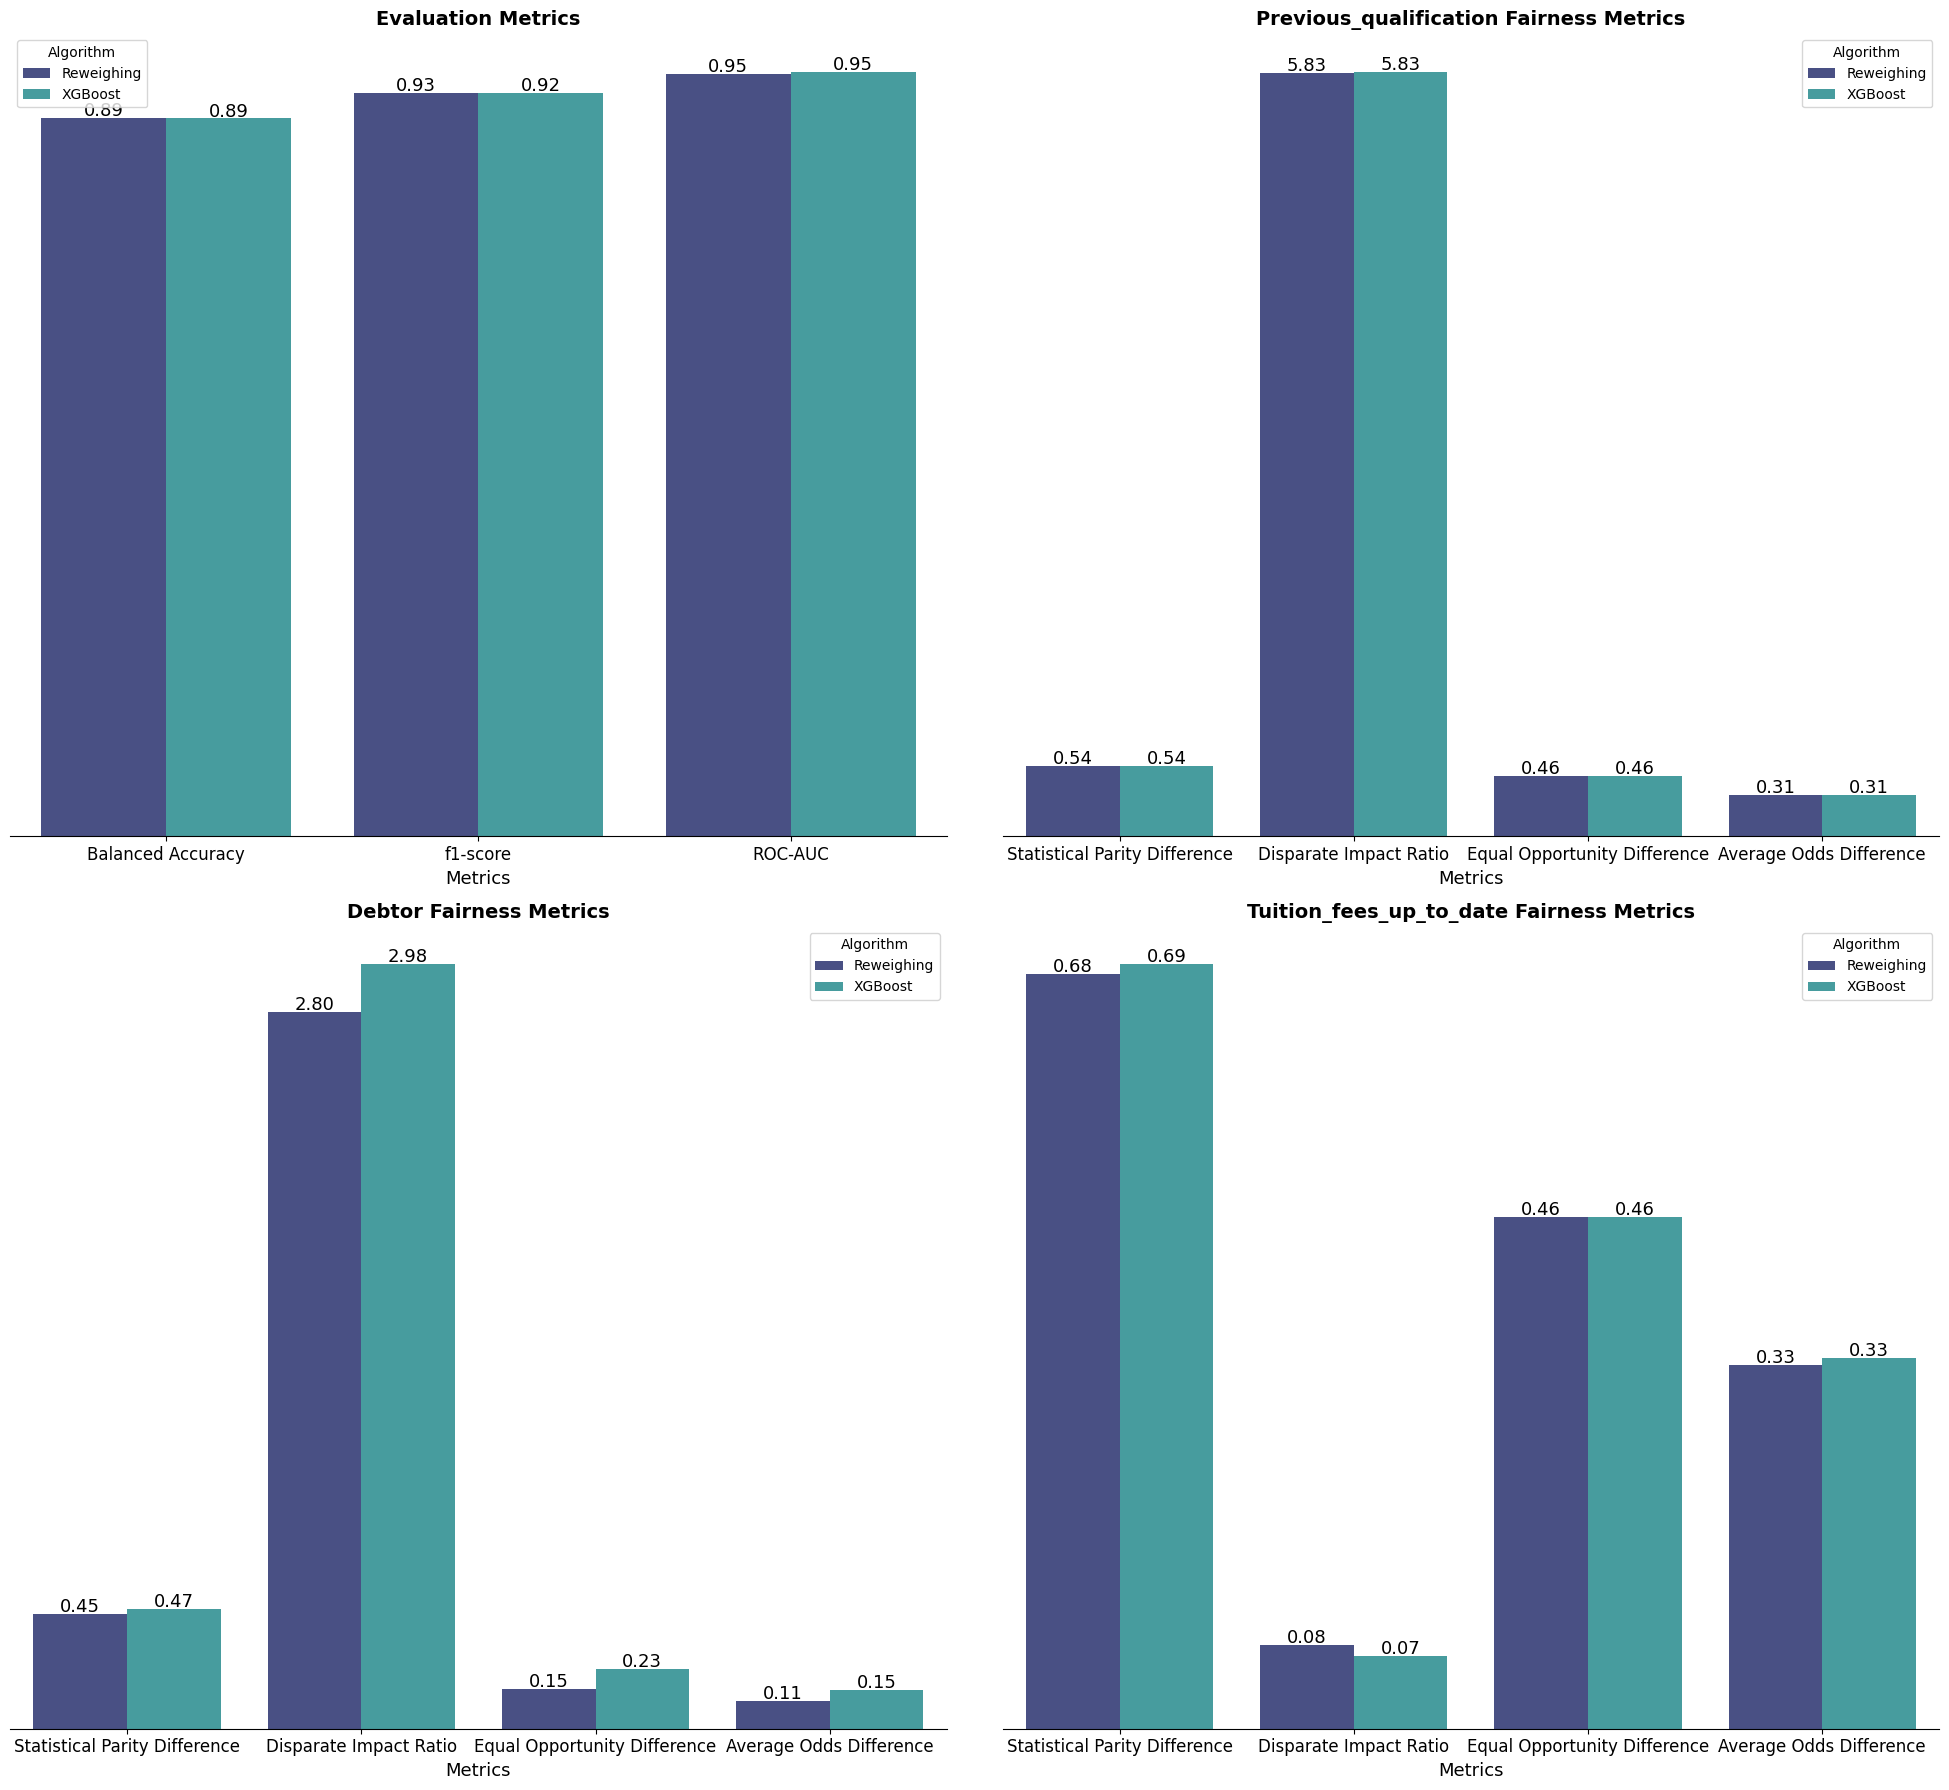

In [10]:
metrics_df = pd.DataFrame({
    'Metric': eval_metrics + eval_metrics,
    'Value': list(cal_df[eval_metrics].iloc[0, :]) + list(xgboost_df[eval_metrics].iloc[0, :]),
    'Algorithm': ['Reweighing'] * 3 + ['XGBoost'] * 3
})
metrics_list=[metrics_df]

for i in range(len(prot_attr)):
    metrics_df = pd.DataFrame({
    'Metric': fairness_metrics + fairness_metrics,
    'Value': list(cal_df[fairness_metrics].iloc[i,:]) + list(xgboost_df[xgboost_df["Attribute"]==prot_attr[i]][fairness_metrics].values[0]),
    'Algorithm': ['Reweighing'] * 4 + ['XGBoost'] * 4
    })
    metrics_df['Value'] = metrics_df['Value'].abs()
    metrics_list.append(metrics_df)


titles =[ "Evaluation Metrics", "Previous_qualification Fairness Metrics", "Debtor Fairness Metrics", "Tuition_fees_up_to_date Fairness Metrics"]
algorithms=['Reject Option based Classification','XGBoost']
plot_2x2_metrics(metrics_list, titles, algorithms)

### Reject Option Based Classification

In [30]:
model=PostProcessingMeta(XGBClassifier(), RejectOptionClassifierCV(prot_attr[1], scoring="average_odds"), random_state=0)

In [31]:
grid=model.fit(X_train, y_train)
y_pred=grid.predict(X_test)
y_proba=grid.predict_proba(X_test)[:,1]

c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\sklearn\utils\metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(
c:\Users\dinat\Υπολογιστής\master thesis\thesis_directory\.venv\lib\site-packages\sklearn\utils\metaestimators.py:121: FutureWarning: if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.
  warnings.warn(


In [32]:
rej_df=create_metrics_dataset(y_test, y_pred, y_proba, prot_attr)

rej_df.to_csv('./data/rej_df.csv')

In [33]:
rej_df

,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,Previous_qualification,0.5969,0.7896,0.9448,0.0315,1.0354,-0.0031,-0.0289
1,Debtor,0.5969,0.7896,0.9448,0.6397,2.7755,0.0769,0.4248
2,Tuition_fees_up_to_date,0.5969,0.7896,0.9448,-0.4409,0.5496,-0.3333,-0.3663


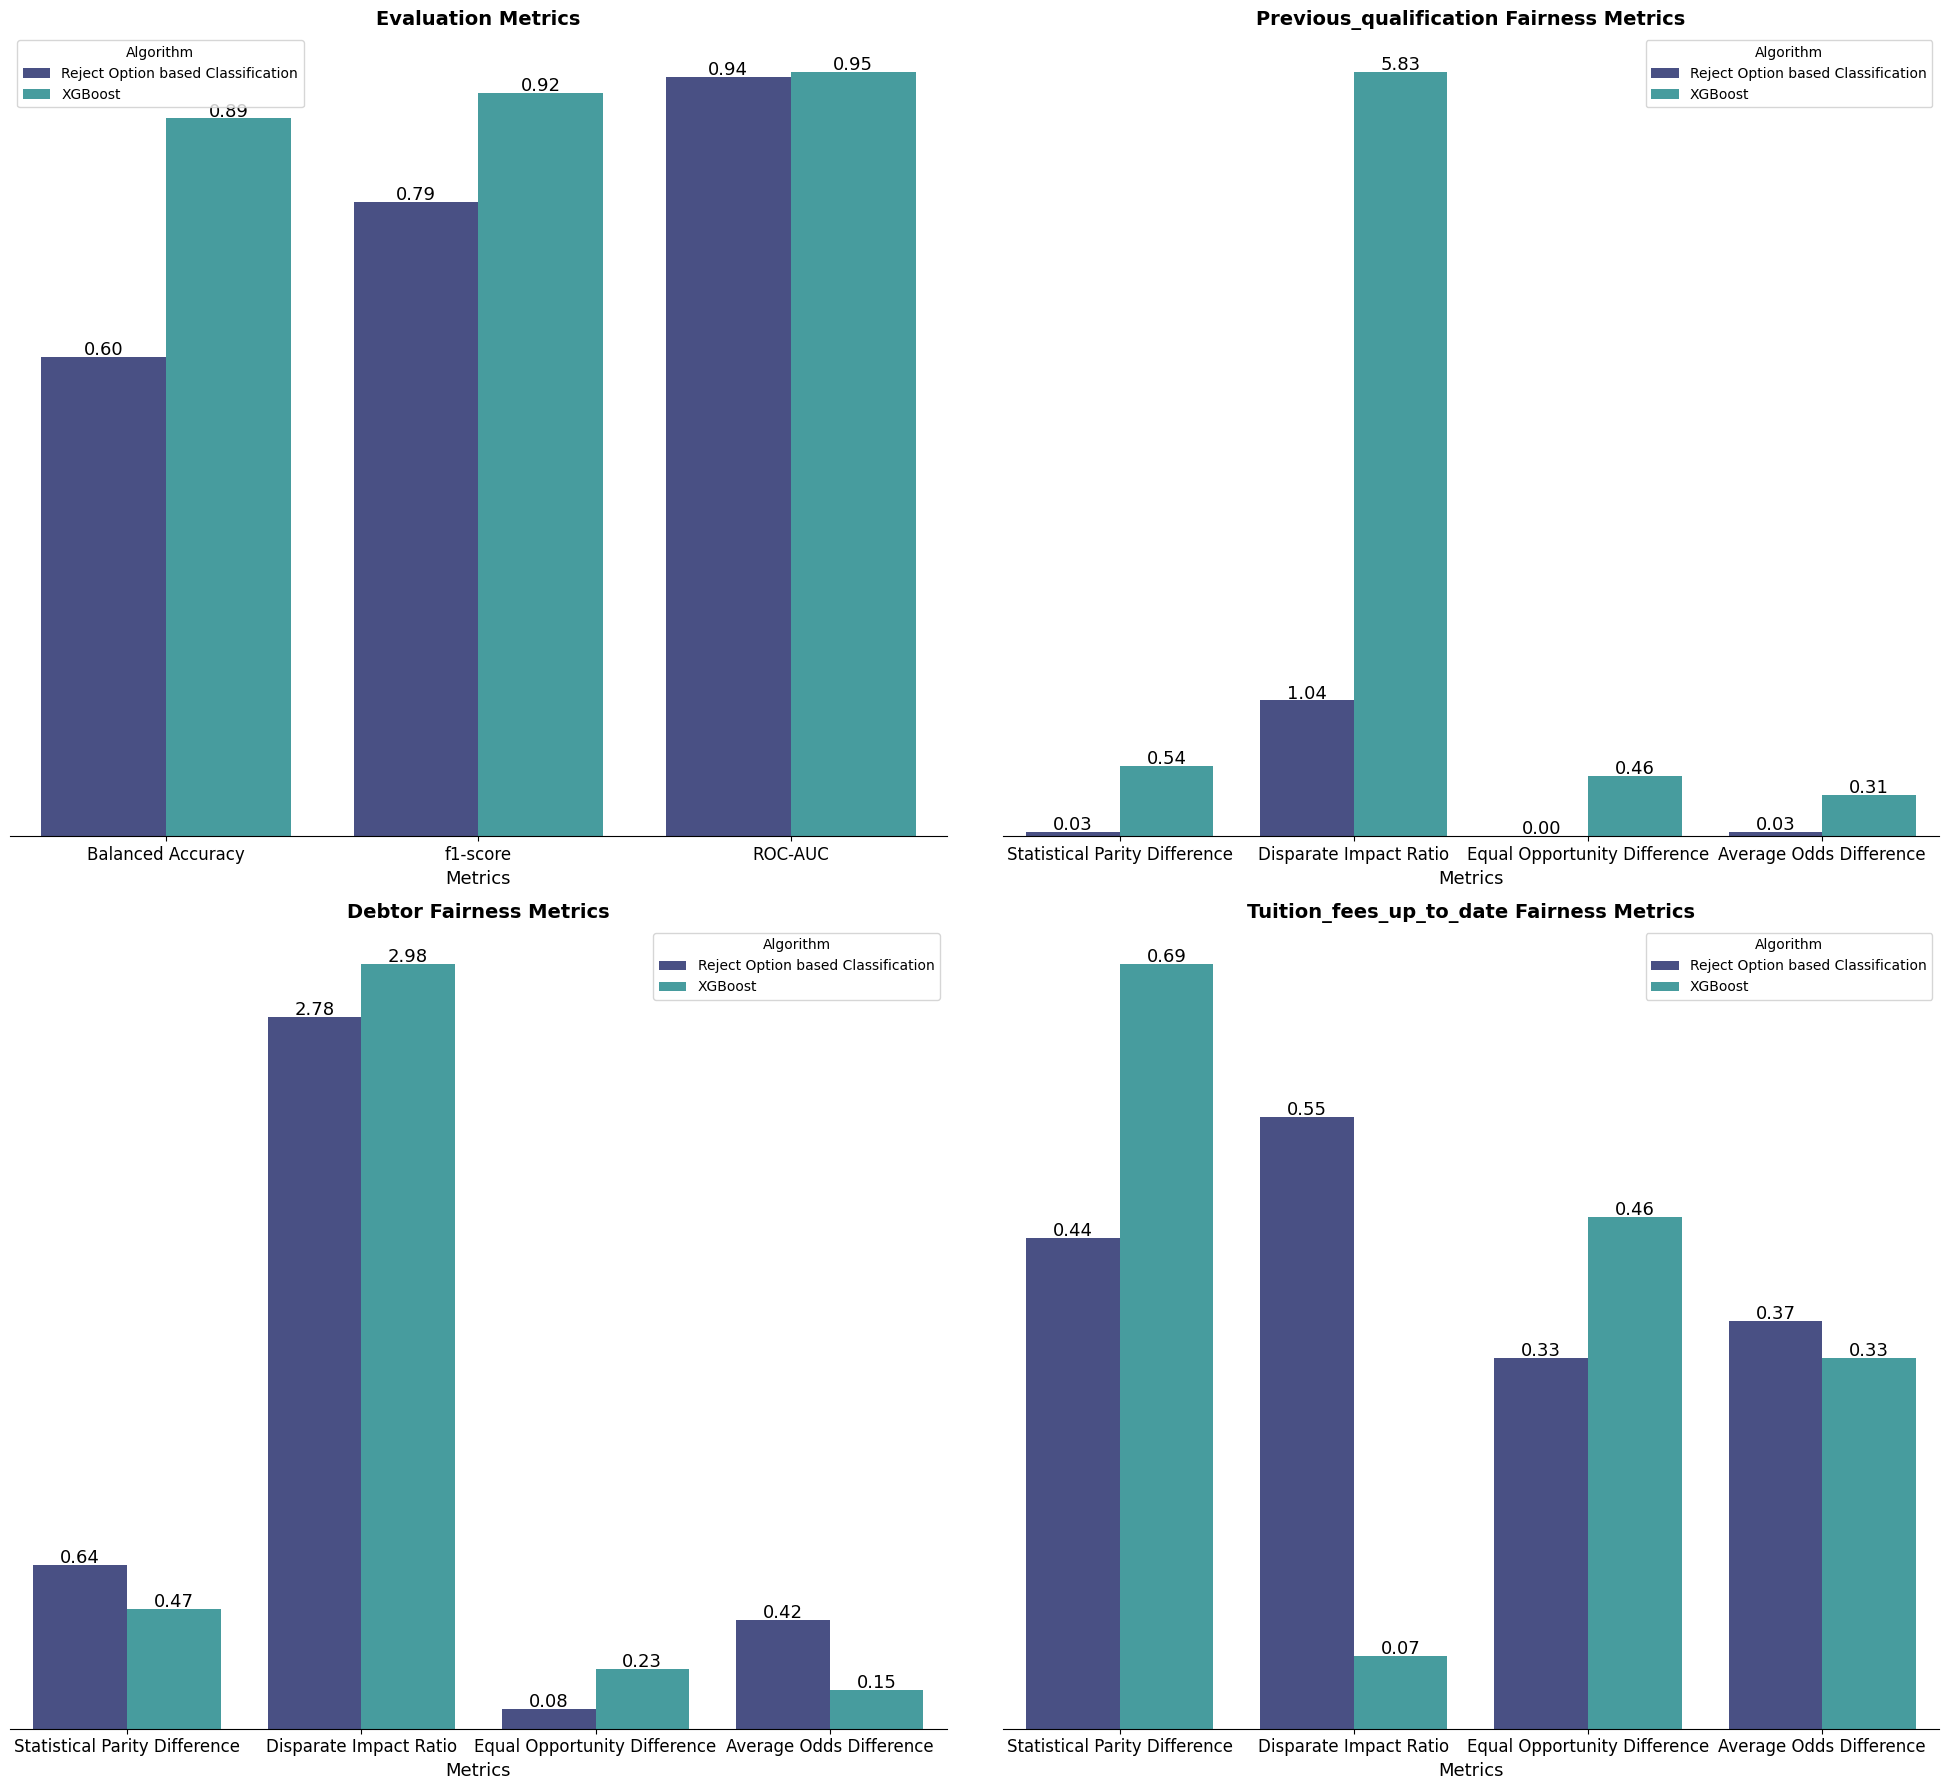

In [34]:
metrics_df = pd.DataFrame({
    'Metric': eval_metrics + eval_metrics,
    'Value': list(rej_df[eval_metrics].iloc[0, :]) + list(xgboost_df[eval_metrics].iloc[0, :]),
    'Algorithm': ['Reject Option based Classification'] * 3 + ['XGBoost'] * 3
})
metrics_list=[metrics_df]

for i in range(len(prot_attr)):
    metrics_df = pd.DataFrame({
    'Metric': fairness_metrics + fairness_metrics,
    'Value': list(rej_df[fairness_metrics].iloc[i,:]) + list(xgboost_df[xgboost_df["Attribute"]==prot_attr[i]][fairness_metrics].values[0]),
    'Algorithm': ['Reject Option based Classification'] * 4 + ['XGBoost'] * 4
    })
    metrics_df['Value'] = metrics_df['Value'].abs()
    metrics_list.append(metrics_df)


titles =[ "Evaluation Metrics", "Previous_qualification Fairness Metrics", "Debtor Fairness Metrics", "Tuition_fees_up_to_date Fairness Metrics"]
algorithms=['Reject Option based Classification','XGBoost']
plot_2x2_metrics(metrics_list, titles, algorithms)

### Results

In [178]:
adv_df=pd.read_csv('./data/adv_df.csv')
cal_df=pd.read_csv('./data/cal_df.csv')
exp_df=pd.read_csv('./data/exp_df.csv')
lfr_df=pd.read_csv('./data/lfr_df.csv')
rej_df=pd.read_csv('./data/rej_df.csv')
reweighing_df=pd.read_csv('./data/reweighing_df.csv')
xgboost_df=pd.read_csv('./data/xgboost_df.csv')

In [70]:
xgboost_df

,Unnamed: 0,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,5,Previous_qualification,0.8934,0.9249,0.9518,0.5370,5.8333,0.4573,0.3145
1,15,Debtor,0.8934,0.9249,0.9518,0.4667,2.9835,0.2344,0.1513
2,16,Tuition_fees_up_to_date,0.8934,0.9249,0.9518,-0.6869,0.0657,-0.4601,-0.3334


In [130]:
# Creating a dataframe for each algorithm
eval_metrics_df = pd.DataFrame({'Algorithm': ['XGBoost', 'Learning Fair Representation', 'Reweighing', 'Adversarial Debiasing', 'Exponentiated Gradient Reduction', 'Calibrated Equalized Odds', 'Reject option based Classification '],
       'Balanced Accuracy': [xgboost_df[['Balanced Accuracy']].values[0][0], lfr_df[['Balanced Accuracy']].values[0][0], reweighing_df[['Balanced Accuracy']].values[0][0], adv_df[['Balanced Accuracy']].values[0][0], exp_df[['Balanced Accuracy']].values[0][0], cal_df[['Balanced Accuracy']].values[0][0], rej_df[['Balanced Accuracy']].values[0][0]],
       'F1-score': [xgboost_df[['f1-score']].values[0][0], lfr_df[['f1-score']].values[0][0], reweighing_df[['f1-score']].values[0][0], adv_df[['f1-score']].values[0][0], exp_df[['f1-score']].values[0][0], cal_df[['f1-score']].values[0][0], rej_df[['f1-score']].values[0][0]], 
       'ROC-AUC': [xgboost_df[['ROC-AUC']].values[0][0], lfr_df[['ROC-AUC']].values[0][0], reweighing_df[['ROC-AUC']].values[0][0], adv_df[['ROC-AUC']].values[0][0], exp_df[['ROC-AUC']].values[0][0], cal_df[['ROC-AUC']].values[0][0], rej_df[['ROC-AUC']].values[0][0]]
       })

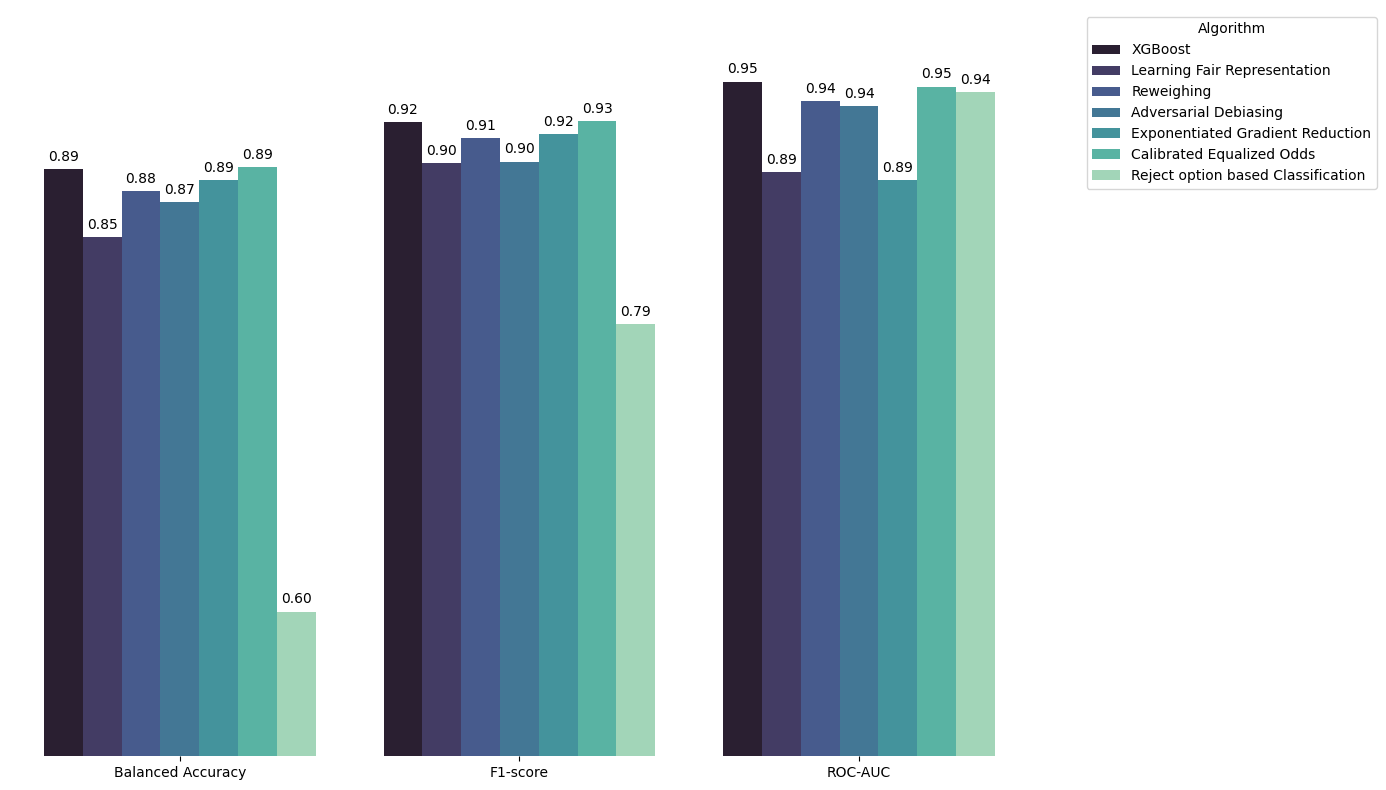

In [162]:
# Melting the DataFrame for seaborn
df_melted = eval_metrics_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Score')

# Creating the bar plot
plt.figure(figsize=(14, 8))
barplot =sns.barplot(x='Metric', y='Score', hue='Algorithm', data=df_melted, palette='mako')
plt.yticks([])
plt.ylim(0.5, 1.0)
plt.ylabel('')
plt.xlabel('')
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine( top=True, right=True, left=True, bottom=True)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

# Display the plot
plt.show()


In [172]:
# Creating a dataframe for each algorithm
prev_qual_metrics_df = pd.DataFrame({'Algorithm': ['XGBoost', 'Learning Fair Representation', 'Reweighing', 'Adversarial Debiasing', 'Exponentiated Gradient Reduction', 'Calibrated Equalized Odds', 'Reject option based Classification '],
       'Statistical Parity Difference': [xgboost_df[['Statistical Parity Difference']].values[0][0], lfr_df[['Statistical Parity Difference']].values[0][0], reweighing_df[['Statistical Parity Difference']].values[0][0], adv_df[['Statistical Parity Difference']].values[0][0], exp_df[['Statistical Parity Difference']].values[0][0], cal_df[['Statistical Parity Difference']].values[0][0], rej_df[['Statistical Parity Difference']].values[0][0]],
       'Disparate Impact Ratio': [xgboost_df[['Disparate Impact Ratio']].values[0][0], lfr_df[['Disparate Impact Ratio']].values[0][0], reweighing_df[['Disparate Impact Ratio']].values[0][0], adv_df[['Disparate Impact Ratio']].values[0][0], exp_df[['Disparate Impact Ratio']].values[0][0], cal_df[['Disparate Impact Ratio']].values[0][0], rej_df[['Disparate Impact Ratio']].values[0][0]], 
       'Equal Opportunity Difference': [xgboost_df[['Equal Opportunity Difference']].values[0][0], lfr_df[['Equal Opportunity Difference']].values[0][0], reweighing_df[['Equal Opportunity Difference']].values[0][0], adv_df[['Equal Opportunity Difference']].values[0][0], exp_df[['Equal Opportunity Difference']].values[0][0], cal_df[['Equal Opportunity Difference']].values[0][0], rej_df[['Equal Opportunity Difference']].values[0][0]],
       'Average Odds Difference': [xgboost_df[['Average Odds Difference']].values[0][0], lfr_df[['Average Odds Difference']].values[0][0], reweighing_df[['Average Odds Difference']].values[0][0], adv_df[['Average Odds Difference']].values[0][0], exp_df[['Average Odds Difference']].values[0][0], cal_df[['Average Odds Difference']].values[0][0], rej_df[['Average Odds Difference']].values[0][0]]
       })

prev_qual_metrics_df[['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']]=prev_qual_metrics_df[['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']].abs()

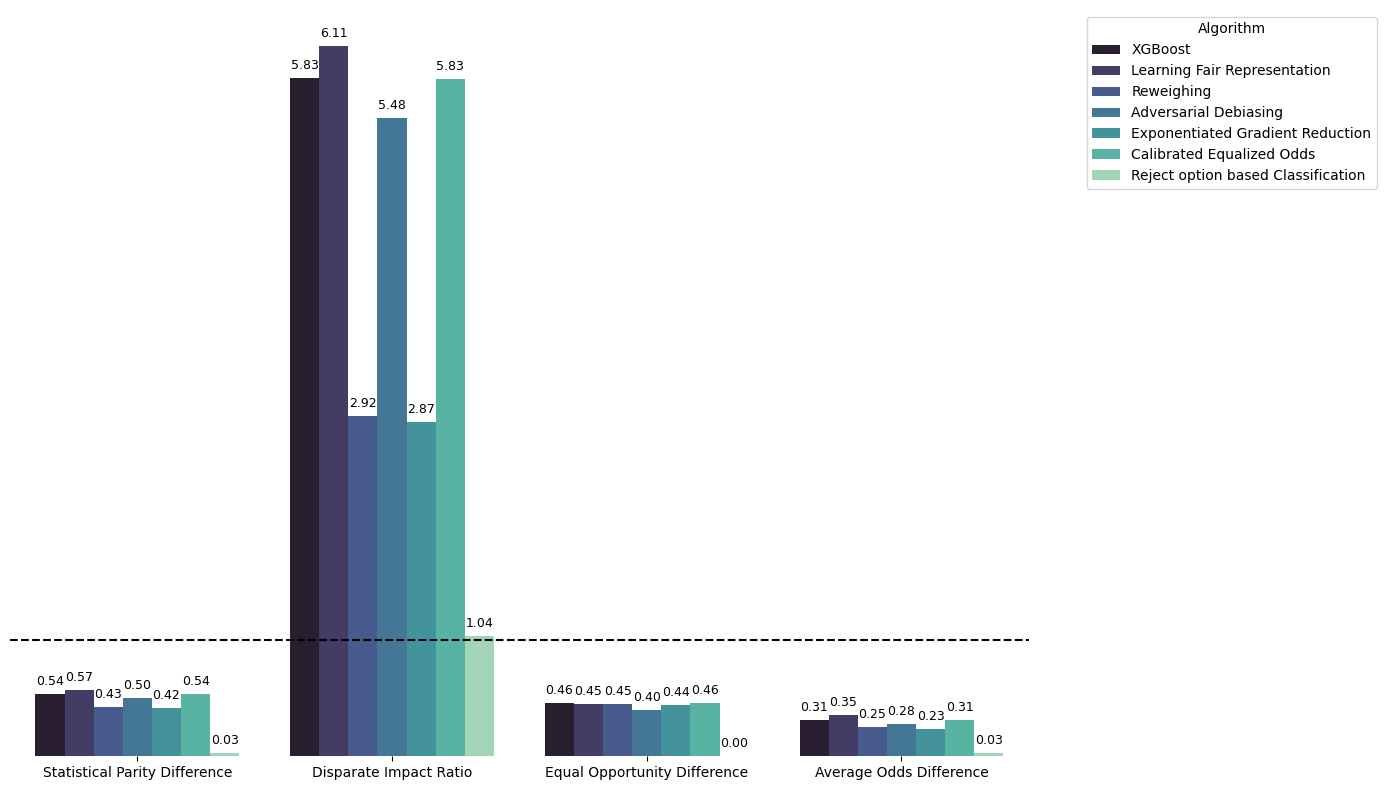

In [173]:
# Melting the DataFrame for seaborn
df_melted = prev_qual_metrics_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Score')

# Creating the bar plot
plt.figure(figsize=(14, 8))
barplot=sns.barplot(x='Metric', y='Score', hue='Algorithm', data=df_melted, palette='mako')
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine( top=True, right=True, left=True, bottom=True)
plt.axhline(y=1, color='black', linestyle='--')
for p in barplot.patches:
    if p.get_height() > 0.00:
        barplot.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        fontsize=9,
                        textcoords = 'offset points')

# Display the plot
plt.show()

In [170]:
# Creating a dataframe for each algorithm
debtor_metrics_df = pd.DataFrame({'Algorithm': ['XGBoost', 'Learning Fair Representation', 'Reweighing', 'Adversarial Debiasing', 'Exponentiated Gradient Reduction', 'Calibrated Equalized Odds', 'Reject option based Classification '],
       'Statistical Parity Difference': [xgboost_df[['Statistical Parity Difference']].values[1][0], lfr_df[['Statistical Parity Difference']].values[1][0], reweighing_df[['Statistical Parity Difference']].values[1][0], adv_df[['Statistical Parity Difference']].values[1][0], exp_df[['Statistical Parity Difference']].values[1][0], cal_df[['Statistical Parity Difference']].values[1][0], rej_df[['Statistical Parity Difference']].values[1][0]],
       'Disparate Impact Ratio': [xgboost_df[['Disparate Impact Ratio']].values[1][0], lfr_df[['Disparate Impact Ratio']].values[1][0], reweighing_df[['Disparate Impact Ratio']].values[1][0], adv_df[['Disparate Impact Ratio']].values[1][0], exp_df[['Disparate Impact Ratio']].values[1][0], cal_df[['Disparate Impact Ratio']].values[1][0], rej_df[['Disparate Impact Ratio']].values[1][0]], 
       'Equal Opportunity Difference': [xgboost_df[['Equal Opportunity Difference']].values[1][0], lfr_df[['Equal Opportunity Difference']].values[1][0], reweighing_df[['Equal Opportunity Difference']].values[1][0], adv_df[['Equal Opportunity Difference']].values[1][0], exp_df[['Equal Opportunity Difference']].values[1][0], cal_df[['Equal Opportunity Difference']].values[1][0], rej_df[['Equal Opportunity Difference']].values[1][0]],
       'Average Odds Difference': [xgboost_df[['Average Odds Difference']].values[1][0], lfr_df[['Average Odds Difference']].values[1][0], reweighing_df[['Average Odds Difference']].values[1][0], adv_df[['Average Odds Difference']].values[1][0], exp_df[['Average Odds Difference']].values[1][0], cal_df[['Average Odds Difference']].values[1][0], rej_df[['Average Odds Difference']].values[1][0]]
       })

debtor_metrics_df[['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']]=debtor_metrics_df[['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']].abs()

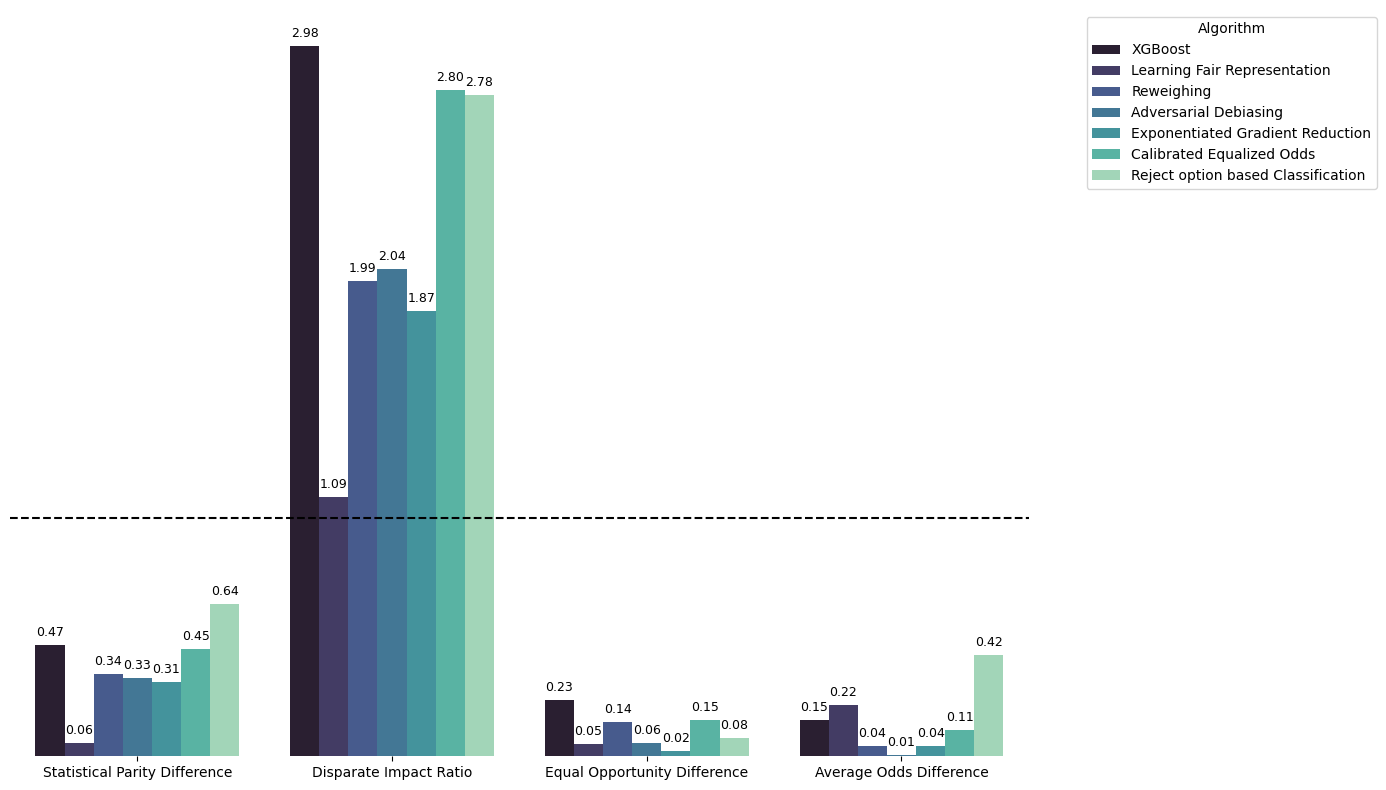

In [171]:
# Melting the DataFrame for seaborn
df_melted = debtor_metrics_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Score')

# Creating the bar plot
plt.figure(figsize=(14, 8))
barplot=sns.barplot(x='Metric', y='Score', hue='Algorithm', data=df_melted, palette='mako')
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine( top=True, right=True, left=True, bottom=True)
plt.axhline(y=1, color='black', linestyle='--')
for p in barplot.patches:
    if p.get_height() > 0.00:
        barplot.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        fontsize=9,
                        textcoords = 'offset points')

# Display the plot
plt.show()

In [167]:
exp_df

,Unnamed: 0,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,0,Previous_qualification,0.8858,0.9169,0.8858,0.4157,2.8708,0.4420,0.2343
1,1,Debtor,0.8858,0.9169,0.8858,0.3134,1.8698,-0.0218,-0.0439
2,2,Tuition_fees_up_to_date,0.8858,0.9169,0.8858,-0.5172,0.2647,0.0599,0.0168


In [179]:
# Creating a dataframe for each algorithm
tuition_fees_metrics_df = pd.DataFrame({'Algorithm': ['XGBoost', 'Learning Fair Representation', 'Reweighing', 'Adversarial Debiasing', 'Exponentiated Gradient Reduction', 'Calibrated Equalized Odds', 'Reject option based Classification '],
       'Statistical Parity Difference': [xgboost_df[['Statistical Parity Difference']].values[2][0], lfr_df[['Statistical Parity Difference']].values[2][0], reweighing_df[['Statistical Parity Difference']].values[2][0], adv_df[['Statistical Parity Difference']].values[2][0], exp_df[['Statistical Parity Difference']].values[2][0], cal_df[['Statistical Parity Difference']].values[2][0], rej_df[['Statistical Parity Difference']].values[2][0]],
       'Disparate Impact Ratio': [xgboost_df[['Disparate Impact Ratio']].values[2][0], lfr_df[['Disparate Impact Ratio']].values[2][0], reweighing_df[['Disparate Impact Ratio']].values[2][0], adv_df[['Disparate Impact Ratio']].values[2][0], exp_df[['Disparate Impact Ratio']].values[2][0], cal_df[['Disparate Impact Ratio']].values[2][0], rej_df[['Disparate Impact Ratio']].values[2][0]], 
       'Equal Opportunity Difference': [xgboost_df[['Equal Opportunity Difference']].values[2][0], lfr_df[['Equal Opportunity Difference']].values[2][0], reweighing_df[['Equal Opportunity Difference']].values[2][0], adv_df[['Equal Opportunity Difference']].values[2][0], exp_df[['Equal Opportunity Difference']].values[2][0], cal_df[['Equal Opportunity Difference']].values[2][0], rej_df[['Equal Opportunity Difference']].values[2][0]],
       'Average Odds Difference': [xgboost_df[['Average Odds Difference']].values[2][0], lfr_df[['Average Odds Difference']].values[2][0], reweighing_df[['Average Odds Difference']].values[2][0], adv_df[['Average Odds Difference']].values[2][0], exp_df[['Average Odds Difference']].values[2][0], cal_df[['Average Odds Difference']].values[2][0], rej_df[['Average Odds Difference']].values[2][0]]
       })

tuition_fees_metrics_df[['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']]=tuition_fees_metrics_df[['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']].abs()

In [183]:
print(tuition_fees_metrics_df.to_dict())

{'Algorithm': {0: 'XGBoost', 1: 'Learning Fair Representation', 2: 'Reweighing', 3: 'Adversarial Debiasing', 4: 'Exponentiated Gradient Reduction', 5: 'Calibrated Equalized Odds', 6: 'Reject option based Classification '}, 'Statistical Parity Difference': {0: 0.6869, 1: 0.507, 2: 0.5389, 3: 0.531, 4: 0.5172, 5: 0.6779, 6: 0.4409}, 'Disparate Impact Ratio': {0: 0.0657, 1: 0.3162, 2: 0.2497, 3: 0.2143, 4: 0.2647, 5: 0.0753, 6: 0.5496}, 'Equal Opportunity Difference': {0: 0.4601, 1: 0.0507, 2: 0.1144, 3: 0.0668, 4: 0.0599, 5: 0.4601, 6: 0.3333}, 'Average Odds Difference': {0: 0.3334, 1: 0.0139, 2: 0.0858, 3: 0.0646, 4: 0.0168, 5: 0.3264, 6: 0.3663}}


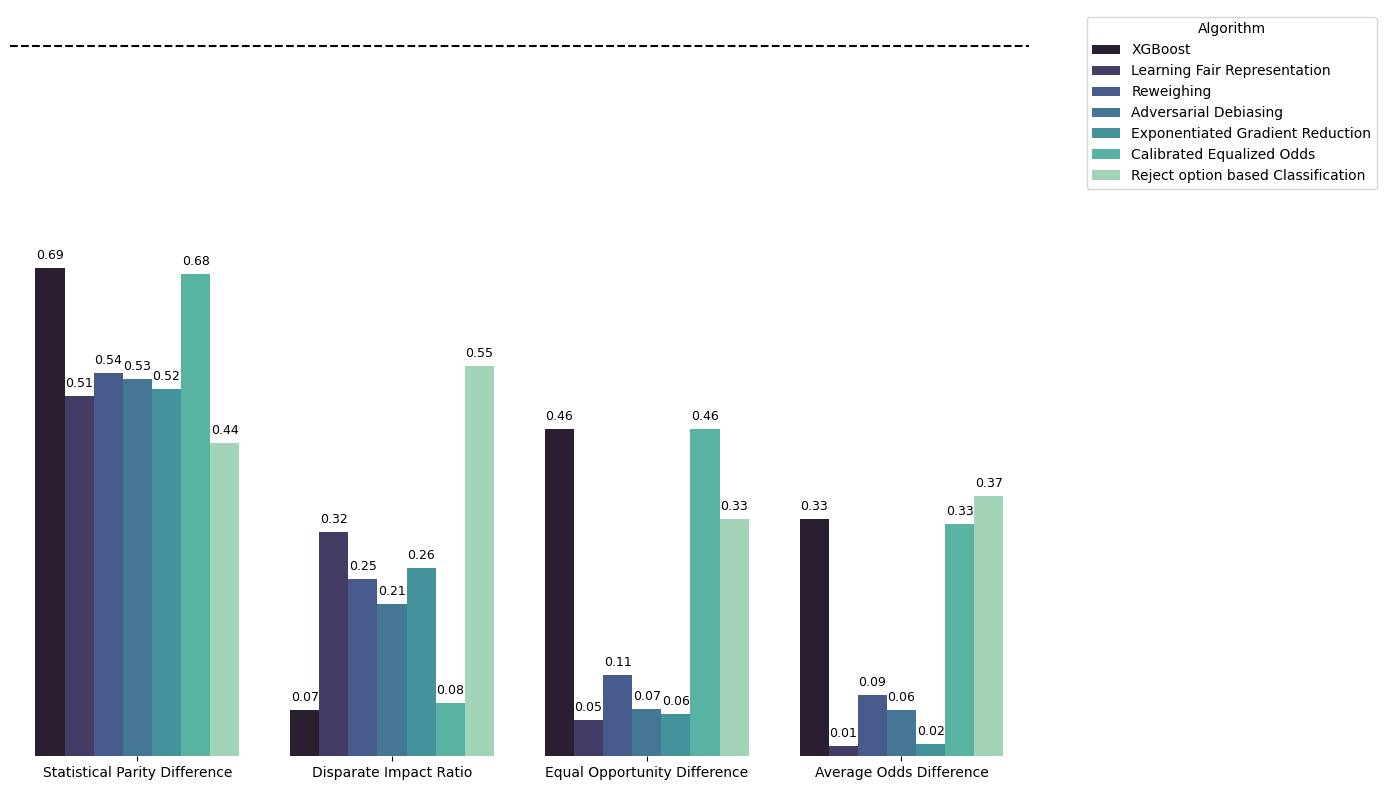

In [181]:
# Melting the DataFrame for seaborn
df_melted = tuition_fees_metrics_df.melt(id_vars='Algorithm', var_name='Metric', value_name='Score')

# Creating the bar plot
plt.figure(figsize=(14, 8))
barplot=sns.barplot(x='Metric', y='Score', hue='Algorithm', data=df_melted, palette='mako')
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine( top=True, right=True, left=True, bottom=True)
for p in barplot.patches:
    if p.get_height() > 0.00:
        barplot.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        fontsize=9,
                        textcoords = 'offset points')


# Display the plot
plt.show()